# 1. Setup

### Import dependecies

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid

In [2]:
# import Tensorflow functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU growth

In [3]:
# Avoid out of memory error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Create folder structure 

In [4]:
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

# creating directories

# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)

# 2. Collect images

### Untar labelled faces in the wild dataset

In [5]:
# uncompress tar gz file
# !tar -xf lfw.tgz

In [6]:
# move LFW images tothe following repository data/negative

for directory in os.listdir('lfw'):
    file_path = os.path.join('lfw', directory)
    for file in os.listdir(file_path):
        EXISING_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EXISING_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

### Collect Positive and anchor images

In [ ]:
# establishing a connection to webcam

cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # cut down frame to 250px*250px
    frame = frame[120:120+250, 200:200+250,:]
    
    # collect anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        image_name = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        image_name = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

# 3. Load Preprocess images

### Get image directories

In [5]:
# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

anchor = tf.data.Dataset.list_files(ANCHOR_PATH + '\*.jpg').take(501)
positive = tf.data.Dataset.list_files(POSITIVE_PATH + '\*.jpg').take(501)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH + '\*.jpg').take(501)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\98c56086-343a-11ed-a762-c8b29b0ea9b0.jpg'

### Preprocessing: Scale and Resize

In [8]:
def preprocess(file_path):
    
    """
        In this function, we first read in the image and then load the image.
        After this we resize the image into 100px * 100px * 3 color channels.
        Last line helps in scaling.
    """
    byte_image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_image)  # loading of image
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    
    return img

### Create labelled dataset

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()

In [11]:
example = samples.next()

### Build train and test partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*example)

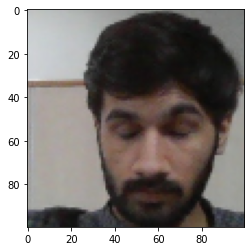

In [14]:
plt.imshow(res[0])

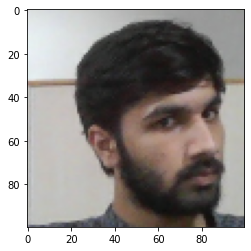

In [15]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:
data_samples = data.as_numpy_iterator()

In [19]:
s = data_samples.next()

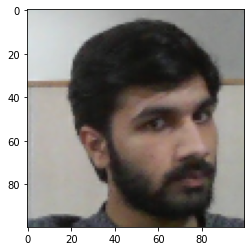

In [20]:
plt.imshow(s[0])

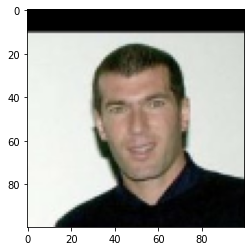

In [21]:
plt.imshow(s[1])

In [22]:
s[2]

0.0

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### Build embedding layers

In [25]:
def make_embedding():
    inp = Input(shape = (100,100,3),name ='input_image')
    
    # First block of model
    
    # we are passing inp as a connecting layer. This is a part of Tensorflow functional API
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp) 
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    # Second block of model
    c2= Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    # Third block of model
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    # Final embedding layer
    
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    
    # f1 flattens the above layer into one dimension
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [26]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build distance layer

In [28]:
# Creating L1Distance layer for Siamese network

class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        
        # inherits the __init__ constructor from Layer class
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        # Calculates the similarity between two image embeddings
        
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
l1 = L1Dist()

### Build siamese model

In [30]:
def make_siamese_model():
    
    # take anchor image as input
    input_image = Input(name = 'input_image', shape = (100,100,3))
    
    # take validation image as input
    validation_image = Input(name = 'validation_image', shape = (100,100,3))
    
    
    # create an object of L1Dist 
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # output layer
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# Model Training

### Setup loss and optimizer

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
# 1e-4 is 0.0001 and it is the learning rate

opt = tf.keras.optimizers.Adam(1e-4)

### Establish checkpoints

In [35]:
"""
    To reload the model from the checkpoint:
        use model.load("path to checkpoint")
    This will load the pre-trained weights into
    the existing model
"""

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
checkpoint_prefix

'./training_checkpoints\\ckpt'

### Build train step function

In [37]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Build training loop

In [38]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [39]:
EPOCHS = 50

In [42]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 50s 569ms/step
0.0938348 0.6085714 0.9906977

 Epoch 2/50
44/44 [==============================] - 24s 553ms/step
0.06216128 0.9433428 0.997006

 Epoch 3/50
44/44 [==============================] - 25s 563ms/step
0.05702303 0.9652174 1.0

 Epoch 4/50
1/1 [==============================] - 0s 296ms/step


44/44 [==============================] - 25s 561ms/step
0.0528837 0.9774648 0.99712646

 Epoch 5/50
44/44 [==============================] - 24s 554ms/step
0.02347262 0.9831461 1.0

 Epoch 6/50
44/44 [==============================] - 24s 542ms/step
0.066621706 0.9861111 1.0

 Epoch 7/50
1/1 [==============================] - 0s 310ms/step


44/44 [==============================] - 24s 540ms/step
0.12799087 0.9711816 0.9911765

 Epoch 8/50
44/44 [==============================] - 24s 539ms/step
0.037444092 0.994302 0.99714285

 Epoch 9/50
44/44 [==============================] - 24s 542ms/step
0.010555974 0.994382 1.0

 Epoch 10/50
44/44 [==============================] - 24s 535ms/step


0.041720472 0.99120235 1.0

 Epoch 11/50
44/44 [==============================] - 26s 582ms/step
0.00028377047 1.0 1.0

 Epoch 12/50
44/44 [==============================] - 24s 544ms/step
0.02145222 1.0 1.0

 Epoch 13/50
44/44 [==============================] - 24s 538ms/step
0.036304943 0.9971182 1.0

 Epoch 14/50
1/1 [==============================] - 0s 319ms/step


44/44 [==============================] - 24s 536ms/step
0.011166726 1.0 1.0

 Epoch 15/50
44/44 [==============================] - 24s 535ms/step
0.3088201 1.0 1.0

 Epoch 16/50
44/44 [==============================] - 24s 544ms/step
0.019162972 0.974359 0.99708456

 Epoch 17/50
1/1 [==============================] - 0s 349ms/step


44/44 [==============================] - 23s 532ms/step
0.0017954072 0.9970588 1.0

 Epoch 18/50
44/44 [==============================] - 23s 527ms/step
0.0006363066 1.0 1.0

 Epoch 19/50
44/44 [==============================] - 23s 523ms/step
0.00016040051 1.0 1.0

 Epoch 20/50
44/44 [==============================] - 23s 523ms/step
0.00014412703 1.0 1.0

 Epoch 21/50
1/1 [==============================] - 0s 310ms/step


44/44 [==============================] - 24s 530ms/step
0.44848257 0.87319887 0.8991098

 Epoch 22/50
44/44 [==============================] - 23s 528ms/step
0.24278723 0.09580839 1.0

 Epoch 23/50
44/44 [==============================] - 23s 521ms/step
0.5210788 0.56948227 1.0

 Epoch 24/50
1/1 [==============================] - 0s 316ms/step


44/44 [==============================] - 23s 520ms/step
0.08520099 0.9775281 1.0

 Epoch 25/50
44/44 [==============================] - 23s 520ms/step
0.047102313 0.99415207 0.99706745

 Epoch 26/50
44/44 [==============================] - 23s 525ms/step
0.0642075 0.99425286 1.0

 Epoch 27/50
1/1 [==============================] - 0s 335ms/step


44/44 [==============================] - 23s 524ms/step
0.05336688 0.9779614 0.99439776

 Epoch 28/50
44/44 [==============================] - 23s 517ms/step
0.00854704 0.994429 1.0

 Epoch 29/50
44/44 [==============================] - 24s 546ms/step
0.01060752 1.0 1.0

 Epoch 30/50
44/44 [==============================] - 24s 551ms/step
0.006076554 1.0 1.0

 Epoch 31/50
1/1 [==============================] - 0s 273ms/step


44/44 [==============================] - 24s 537ms/step
0.0018207995 1.0 1.0

 Epoch 32/50
44/44 [==============================] - 24s 546ms/step
0.0030338462 1.0 1.0

 Epoch 33/50
44/44 [==============================] - 24s 536ms/step
0.023723345 1.0 1.0

 Epoch 34/50
1/1 [==============================] - 0s 289ms/step


44/44 [==============================] - 23s 530ms/step
0.0057845656 1.0 1.0

 Epoch 35/50
44/44 [==============================] - 24s 547ms/step
0.004573626 1.0 1.0

 Epoch 36/50
44/44 [==============================] - 24s 540ms/step
0.00095986616 1.0 1.0

 Epoch 37/50
1/1 [==============================] - 0s 261ms/step


44/44 [==============================] - 24s 539ms/step
0.00043737175 1.0 1.0

 Epoch 38/50
44/44 [==============================] - 24s 552ms/step
0.0073409984 1.0 1.0

 Epoch 39/50
44/44 [==============================] - 24s 548ms/step
0.0005575484 1.0 1.0

 Epoch 40/50
44/44 [==============================] - 24s 549ms/step
0.00042611442 1.0 1.0

 Epoch 41/50
1/1 [==============================] - 0s 286ms/step


44/44 [==============================] - 24s 530ms/step
0.00047878333 1.0 1.0

 Epoch 42/50
44/44 [==============================] - 24s 535ms/step
0.002103583 1.0 1.0

 Epoch 43/50
44/44 [==============================] - 23s 529ms/step
0.0017454189 1.0 1.0

 Epoch 44/50
1/1 [==============================] - 0s 306ms/step


44/44 [==============================] - 23s 529ms/step
0.0020735506 1.0 1.0

 Epoch 45/50
44/44 [==============================] - 24s 534ms/step
0.0009177467 1.0 1.0

 Epoch 46/50
44/44 [==============================] - 23s 528ms/step
0.0012346001 1.0 1.0

 Epoch 47/50
44/44 [==============================] - 24s 541ms/step
0.0013475505 1.0 1.0

 Epoch 48/50
1/1 [==============================] - 0s 247ms/step


44/44 [==============================] - 24s 538ms/step
0.00014678582 1.0 1.0

 Epoch 49/50
44/44 [==============================] - 23s 529ms/step
0.00021717438 1.0 1.0

 Epoch 50/50
44/44 [==============================] - 24s 535ms/step
0.0008517783 1.0 1.0


# 6. Evaluate the model

### Import metrics

In [44]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [45]:
# get a batch of test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [46]:
# predict results

y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 64ms/step


array([[1.0000000e+00],
       [5.3102974e-07],
       [1.3931616e-06],
       [9.9999928e-01],
       [5.4754423e-07],
       [9.6421582e-09],
       [1.0000000e+00],
       [1.0893056e-08],
       [1.4791800e-05],
       [9.9990416e-01],
       [9.9999475e-01],
       [9.9999321e-01],
       [9.9987137e-01],
       [1.5021376e-06],
       [3.3775941e-04],
       [1.3360486e-08]], dtype=float32)

In [48]:
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [49]:
y_hat

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]

In [50]:
y_true

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

### Calculate metrics

In [51]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [52]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [53]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 25ms/step
1.0 1.0


### Plot results

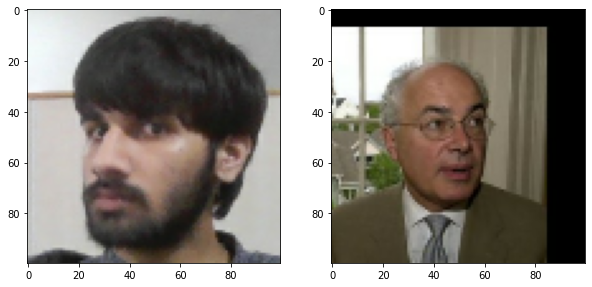

In [54]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7. Save model

In [55]:
# Save weights
siamese_model.save('siamesemodel.h5')


In [59]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [60]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 160ms/step


array([[1.02061626e-04],
       [4.86914260e-08],
       [5.51581991e-07],
       [3.61168762e-09],
       [2.54157527e-07],
       [9.99999881e-01],
       [7.87303543e-06],
       [5.57776048e-09],
       [9.92274106e-01],
       [9.99942541e-01],
       [4.63170116e-04],
       [9.96592939e-01],
       [9.99999881e-01]], dtype=float32)

In [61]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# 8. Real-time testing

### Verification function

In [ ]:
"""
    Access webcam and grab input image and verify the image in a number of positive samples
    
"""

# Refer this article to get better understanding of Siamese Network

### <https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee>